# Projekt 4: Generalna ocena jakości modeli przestrzennych RNA

In [1]:
# %pip install pandas biopython joblib scikit-learn catboost

In [18]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from joblib import Parallel, delayed
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split

1. Zapoznanie się z udostępnionymi zbiorami danych i ewentualne przetransformowanie ich do postaci ułatwiającej zastosowanie technik sztucznej inteligencji np. integracja danych składowych przechowywanych w różnych formatach z wykorzystaniem jednej spójnej reprezentacji.

In [3]:
DATASET_PATH = Path("./resources/datasets/RNA-Puzzles")

challenges = [f"pz{index:02}" for index in range(1, 11)]

In [4]:
def parse_motifs(challenges: list[str]) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for challenge in challenges:
        current_df = pd.read_csv(
            DATASET_PATH / f"{challenge}/filter-results.txt",
            sep="\t",
            header=None,
            names=[
                "filename",
                "number_of_segments",
                "number_of_residues",
                "nucleotide_ranges",
                "sequences",
            ],
        )
        current_df["challenge_number"] = challenge
        result_df = pd.concat([result_df, current_df])

    result_df = result_df[result_df["number_of_segments"] >= 3]
    return result_df.reset_index(drop=True)


motifs = parse_motifs(challenges)
motifs

,filename,number_of_segments,number_of_residues,nucleotide_ranges,sequences,challenge_number
0,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
1,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
2,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
3,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
4,1_solution_0_rpr_A_8_G,3,24,"A4-A12, B5-B12, B15-B21","CCGCGCCAU, CGCGCCAU, CUGUGGC",pz01
...,...,...,...,...,...,...
673,10_0_solution_4LCK_rpr_B_55_C,3,32,"A48-A63, B16-B21, B50-B59","AGGAUAGUGAAAGCUA, UGGUAG, GGGUUCGAAU",pz10
674,10_0_solution_4LCK_rpr_B_56_G,3,38,"A48-A64, B15-B22, B49-B61","AGGAUAGUGAAAGCUAG, GUGGUAGA, CGGGUUCGAAUCC",pz10
675,10_0_solution_4LCK_rpr_B_57_A,4,42,"A49-A54, A58-A64, B14-B22, B44-B63","GGAUAG, AAGCUAG, AGUGGUAGA, GGUCGCGGGUUCGAAUCCCG",pz10
676,10_0_solution_4LCK_rpr_B_58_A,4,43,"A59-A63, B6-B11, B13-B23, B43-B63","AGCUA, AGUAGU, CAGUGGUAGAA, GGGUCGCGGGUUCGAAUCCCG",pz10


In [5]:
def parse_xml_file(file_path: Path) -> pd.DataFrame:
    tree = ET.parse(file_path)
    root = tree.getroot()
    return pd.DataFrame(
        [
            {
                "filename": child.find("description").find("filename").text,
                "score": child.find("score").text,
            }
            for child in root
        ]
    )


def parse_scores(motifs: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for index, row in motifs.iterrows():
        core_path = DATASET_PATH / f"{row['challenge_number']}"
        xml_path = core_path / f"{row['filename']}-rmsd.xml"

        if xml_path.exists():
            current_df = parse_xml_file(xml_path)
            current_df["solution_directory"] = row["filename"]
            current_df["dataset_files_path"] = core_path / (
                f"{row['filename']}/" + current_df["filename"].apply(lambda x: x[:-4])
            )
            result_df = pd.concat([result_df, current_df])
        else:
            motifs.drop(index, inplace=True)

    return result_df


scores = parse_scores(motifs)
scores

,filename,score,solution_directory,dataset_files_path
0,1_bujnicki_1_rpr.pdb,4.769,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
1,1_bujnicki_2_rpr.pdb,4.594,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
2,1_bujnicki_3_rpr.pdb,3.921,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
3,1_bujnicki_4_rpr.pdb,4.522,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
4,1_bujnicki_5_rpr.pdb,4.616,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
...,...,...,...,...
21,10_DING_5_rpr.pdb,4.516,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
22,10_DING_6_rpr.pdb,3.939,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
23,10_DING_7_rpr.pdb,4.639,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
24,10_DING_8_rpr.pdb,5.66,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...


In [6]:
def parse_pdb_file(file_path: Path) -> pd.DataFrame:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("PDB_structure", f"{file_path}.pdb")

    pdb_data: list = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    pdb_data.append(
                        {
                            "atom_id": atom.serial_number,
                            "atom_name": atom.name,
                            "residue_name": residue.resname,
                            "chain_id": chain.id,
                            "residue_number": residue.id[1],
                            "x": atom.coord[0],
                            "y": atom.coord[1],
                            "z": atom.coord[2],
                            "occupancy": atom.occupancy,
                            "temperature_factor": atom.bfactor,
                        }
                    )
    return pd.DataFrame(pdb_data)


def parse_tor_file(file_path: Path, keep_ids: bool = False) -> pd.DataFrame:
    result_df = pd.read_csv(f"{file_path}.tor", sep="\s+")
    return (
        result_df.drop(columns=["Chain", "ResNum", "Name", "iCode"])
        if not keep_ids
        else result_df.rename(
            columns={
                "Chain": "chain_id",
                "ResNum": "residue_number",
                "Name": "residue_name",
                "iCode": "icode",
            }
        )
    )

2. Krótkie zapoznanie się z dostępnymi przestrzeniami reprezentacji struktur 3D RNA (przestrzenie kartezjańska i kątów torsyjnych) i ich formatami zapisu. Wybór obiecującej przestrzeni na której będziecie Państwo bazować wraz z uzasadnieniem.

In [7]:
example_path = scores["dataset_files_path"].values[0]
example_pdb = parse_pdb_file(example_path)
example_pdb.head()

,atom_id,atom_name,residue_name,chain_id,residue_number,x,y,z,occupancy,temperature_factor
0,1,C1',C,A,1,-20.322001,-0.227,69.922997,1.0,0.0
1,2,C2,C,A,1,-19.306999,-1.206,71.968002,1.0,0.0
2,3,C2',C,A,1,-19.379999,0.818,69.327003,1.0,0.0
3,4,C3',C,A,1,-19.302999,0.409,67.860001,1.0,0.0
4,5,C4,C,A,1,-18.016001,-3.167,71.891998,1.0,0.0


In [8]:
example_tor = parse_tor_file(example_path, keep_ids=True)
example_tor.head()

,chain_id,residue_number,icode,residue_name,alpha,beta,gamma,delta,epsilon,zeta,chi
0,A,1,-,C,-,-176.137,59.054,81.122,-174.56,-80.489,-145.907
1,A,2,-,C,161.855,-159.318,166.249,89.951,-117.771,-80.79,-160.341
2,A,3,-,G,-73.596,158.659,64.143,82.278,-147.484,-77.638,-164.295
3,A,4,-,C,-75.485,171.898,62.668,83.346,-152.214,-73.751,-155.038
4,A,5,-,C,-78.552,172.551,62.180,81.483,-152.556,-73.703,-151.534


3. Określenie procentowych progów pozwalających podzielić dostępny zbiór danych na część treningową, walidacyjną i ewaluacyjną. Czy rozmiar dostępnego zbioru jest wystarczający? Czy należy go rozbudować? Jeśli tak to w jaki sposób?

In [9]:
# train-validation-test splits -> 70-15-15
VALID_TEST_SIZE: float = 0.15
TRAIN_SIZE: float = 1 - (2 * VALID_TEST_SIZE)

assert TRAIN_SIZE > 0 and VALID_TEST_SIZE > 0

4. Określenie sposobu reprezentacji wiedzy, którą dysponujemy (tzn. wektora cech). Czy stosowane będą techniki identyfikacji najistotniejszych cech? Jeśli tak to jakie?

In [10]:
def find_max_tor_lines(scores: pd.DataFrame) -> int:
    return scores["dataset_files_path"].apply(lambda x: len(parse_tor_file(x))).max()


max_tor_lines = find_max_tor_lines(scores)
max_tor_lines

61

In [11]:
REPRESENTATIONS_PATH = Path("./resources/datasets/representations")
TOR_DATASET_PATH = REPRESENTATIONS_PATH / "tor_dataset.csv"

NUMBER_OF_ANGLES = 7
FILL_FEATURES_TO = max_tor_lines * NUMBER_OF_ANGLES  # 61 * 7 = 427


def preprocess_tor_data(tor_data: pd.DataFrame, missing_value: int = 0) -> np.ndarray:
    tor_data = tor_data.replace("-", missing_value).astype(float)
    tor_data = tor_data.values.flatten()
    padding_needed = max(0, FILL_FEATURES_TO - len(tor_data))
    padded_tor_data = np.pad(
        tor_data, pad_width=(0, padding_needed), mode="constant", constant_values=missing_value
    )
    return padded_tor_data


def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    def normalize_column(column: pd.Series) -> pd.Series:
        non_zero_values = column[column != 0]
        min_val = non_zero_values.min()
        max_val = non_zero_values.max()

        column[column != 0] = (
            2 * (non_zero_values - min_val) / (max_val - min_val) - 1 if max_val != min_val else 0
        )
        return column

    return df.apply(normalize_column, axis="columns")


def prepare_tor_dataset(scores: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for _, row in scores.iterrows():
        tor_data = parse_tor_file(row["dataset_files_path"])
        preprocessed_tor_data = preprocess_tor_data(tor_data)

        current_df = pd.DataFrame(preprocessed_tor_data).T
        current_df["score"] = row["score"]
        result_df = pd.concat([result_df, current_df])

    score_copy = result_df["score"].copy()
    result_df = normalize_data(result_df.drop(columns=["score"]))
    result_df["score"] = score_copy
    return result_df


def parallel_processing(scores: pd.DataFrame) -> pd.DataFrame:
    cores = max(1, os.cpu_count() - 1)
    data_splits = np.array_split(scores, cores)
    fn = delayed(prepare_tor_dataset)
    results = Parallel(n_jobs=cores, verbose=10)(fn(data_split) for data_split in data_splits)
    return pd.concat(results)


def make_tor_dataset_csv(scores: pd.DataFrame) -> None:
    dataset = parallel_processing(scores)
    dataset.to_csv(TOR_DATASET_PATH, index=False)


if not TOR_DATASET_PATH.exists():
    make_tor_dataset_csv(scores)

In [12]:
tor_dataset = pd.read_csv(TOR_DATASET_PATH)
tor_dataset

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,score
0,0.0,-0.978661,0.339637,0.463333,-0.969821,-0.442532,-0.809215,0.915860,-0.884387,0.940489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.769
1,0.0,0.925007,0.302262,0.458506,-0.919853,-0.430515,-0.901528,-0.367817,0.971242,0.248807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.594
2,0.0,0.969942,0.310983,0.444815,-0.804548,-0.577312,-0.902394,0.905048,-0.871336,0.939470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.921
3,0.0,-0.907328,0.252716,0.409614,0.987071,-0.394564,-0.753726,-0.340666,0.941621,0.283139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.522
4,0.0,0.960478,0.304328,0.482642,-0.788699,-0.441201,-0.924806,-0.395413,1.000000,0.318126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20951,0.0,0.921765,0.350060,0.465399,-0.833842,-0.343431,-0.887391,-0.499000,0.832146,0.583481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.516
20952,0.0,0.933915,0.485690,0.427908,-0.831433,-0.394316,-0.926236,-0.485149,0.825322,0.675647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.939
20953,0.0,0.904442,0.422146,0.510393,-0.825556,-0.387512,-0.887714,-0.412740,0.901270,0.289614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.639
20954,0.0,0.920129,0.353021,0.379568,-0.880728,-0.366675,-0.906016,-0.484275,0.908835,0.714776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.660


In [13]:
def preprocess_tor_dataset(dataset: pd.DataFrame) -> tuple[np.array, np.array]:
    X = dataset.drop(dataset.columns[-1], axis=1)
    y = dataset[dataset.columns[-1]]
    return np.array(X), np.array(y)


X, y = preprocess_tor_dataset(tor_dataset)
X.shape, y.shape

((20956, 427), (20956,))

In [14]:
RANDOM_STATE: int = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE
)

print(
    f"""
    Train size: {X_train.shape} [{X_train.shape[0] / X.shape[0] * 100:.2f}%]
    Valid size: {X_valid.shape} [{X_valid.shape[0] / X.shape[0] * 100:.2f}%]
    Test  size: {X_test.shape} [{X_test.shape[0] / X.shape[0] * 100:.2f}%]
    """
)


    Train size: (14669, 427) [70.00%]
    Valid size: (3143, 427) [15.00%]
    Test  size: (3144, 427) [15.00%]
    


5. Wybór obiecujących technik uczenia maszynowego, które uważacie Państwo, że powinny się sprawdzić podczas rozwiązywania postawionego problemu wraz z uzasadnieniem (np. głębokie sieci neuronowe, SVM, RandomForest ,itd.).

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor

common_params = {"verbose": True, "random_state": RANDOM_STATE}

regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=100,
                             max_depth=None,
                             n_jobs=-1,
                             criterion="squared_error",
                             **common_params),
    
    "MLP": MLPRegressor(validation_fraction=VALID_TEST_SIZE,
                    alpha=0.01,
                    hidden_layer_sizes=(300, 200, 100),
                    # hidden_layer_sizes=(100, 200, 400, 200, 100),
                    max_iter=50, 
                    **common_params)
    
}

6. Iteracyjne przeprowadzenie procesu uczenia, określenie wartości parametrów kluczowych dla tego procesu (np. zastosowana funkcja straty, learning rate, optimizer, itd.) i wskazanie czy natrafiliście Państwo na jakieś problemy podczas tego procesu np. przeuczenie i jak Państwo sobie z tymi problemami poradziliście o ile rzeczywiście wystąpiły?

7. Optymalizacja wartości hiperparametrów – czy warto je optymalizować w przypadku rozpatrywanego problemu? Jeśli tak to w jaki sposób?

8. Wybór i uzasadnienie zastosowanych miar oceny, przeprowadzenie procesu ewaluacji uzyskanego(ych) modelu(i), podsumowanie i analiza uzyskanych wyników.

In [19]:

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def make_prediction(Regressor, param_grid: Optional[dict] = None):
    regr = (
        GridSearchCV(Regressor,
                     param_grid,
                     scoring=rmse_scorer,
                     n_jobs=-1,
                     verbose=1,
                     cv=3,
                     return_train_score=True)
        if param_grid
        else Regressor
    )

    regr.fit(X_train, y_train)
    if param_grid:
        print(f"Best params: {regr.best_params_}")

    # y_pred = regr.predict(X_test)
    # return {
    #     "model": regr,
    #     "model_name": type(Regressor).__name__,
    #     "Best params": regr.best_params_,
    #     # "Best score": regr.best_score_,
    #     "predictions": y_pred,
    #     "RMSE": root_mean_squared_error(y_test, y_pred)
    # }

    y_pred = regr.predict(X_test)
    print(f"{type(Regressor).__name__} RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    return regr

In [ ]:
grid = {
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, 30],
    },
    "MLP": {
        "hidden_layer_sizes": [(100,), (200,), (200, 100), (300, 200, 100)],
        "alpha": [0.0001, 0.001, 0.01],
        "max_iter": [50],
    },
    "SGD": {
        "alpha": [0.0001, 0.001, 0.01],
        "penalty": ["l2"],
        "learning_rate": ["adaptive"],
        "max_iter": [50, 100, 200, 300, 400],
    },

}

# regr = make_prediction(regressors["MLP"], grid["MLP"])

In [24]:
from sklearn.model_selection import KFold

# regr = SGDRegressor(validation_fraction=VALID_TEST_SIZE,
#                     alpha=0.001,
#                     penalty="l2",
#                     learning_rate="adaptive",
#                     max_iter=100, 
#                     **common_params)

regr = MLPRegressor(validation_fraction=VALID_TEST_SIZE,
                    alpha=0.01,
                    hidden_layer_sizes=(300, 200, 100),
                    # hidden_layer_sizes=(100, 200, 400, 200, 100),
                    max_iter=50, 
                    **common_params)

# regr = RandomForestRegressor(n_estimators=100,
#                              max_depth=None,
#                              n_jobs=-1,
#                              criterion="squared_error",
#                              **common_params)


kf = KFold(n_splits=50, shuffle=True, random_state=RANDOM_STATE)
train_scores = {"RMSE": [], "MSE": [], "MAE": []}
test_scores = {"RMSE": [], "MSE": [], "MAE": []}


for train_index, test_index in kf.split(X_train):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    # track the fitting process
    regr.partial_fit(X_train_kf, y_train_kf)

    y_pred_test = regr.predict(X_test_kf)
    y_pred_train = regr.predict(X_train_kf)
    train_scores["RMSE"].append(root_mean_squared_error(y_train_kf, y_pred_train))
    test_scores["RMSE"].append(root_mean_squared_error(y_test_kf, y_pred_test))

    train_scores["MSE"].append(mean_squared_error(y_train_kf, y_pred_train))
    test_scores["MSE"].append(mean_squared_error(y_test_kf, y_pred_test))

    train_scores["MAE"].append(mean_absolute_error(y_train_kf, y_pred_train))
    test_scores["MAE"].append(mean_absolute_error(y_test_kf, y_pred_test))

    print(f"KFold RMSE score: {root_mean_squared_error(y_test_kf, y_pred_test)}")

Iteration 1, loss = 26.09685904
KFold RMSE score: 7.5110405695436535
Iteration 1, loss = 21.37560436
KFold RMSE score: 7.242734385726192
Iteration 1, loss = 19.20551503
KFold RMSE score: 5.929386618456046
Iteration 1, loss = 16.77084899
KFold RMSE score: 5.918388861252335
Iteration 1, loss = 14.81442524
KFold RMSE score: 4.71767907806524
Iteration 1, loss = 12.90368764
KFold RMSE score: 3.9469871618515717
Iteration 1, loss = 11.31492815
KFold RMSE score: 5.109815123693159
Iteration 1, loss = 10.23878006
KFold RMSE score: 3.882901738493524
Iteration 1, loss = 9.21030867
KFold RMSE score: 3.0322806730283642
Iteration 1, loss = 8.08249596
KFold RMSE score: 4.155166663757377
Iteration 1, loss = 7.59663222
KFold RMSE score: 3.5072422256949816
Iteration 1, loss = 6.98265759
KFold RMSE score: 3.258034129394364
Iteration 1, loss = 5.96310158
KFold RMSE score: 4.711416465526309
Iteration 1, loss = 5.64777610
KFold RMSE score: 3.536809404390985
Iteration 1, loss = 5.24893472
KFold RMSE score: 3.

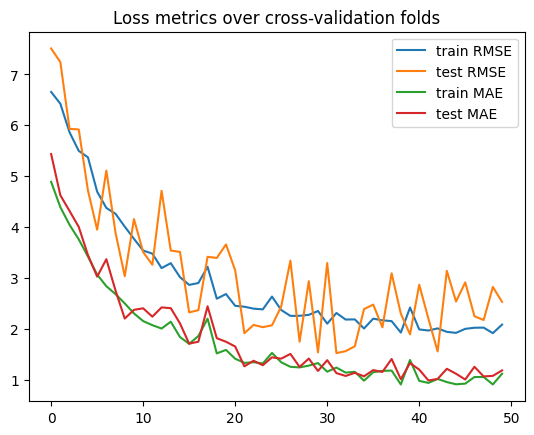

In [29]:
import matplotlib.pyplot as plt

plt.plot(train_scores["RMSE"], label="train RMSE")
plt.plot(test_scores["RMSE"], label="test RMSE")
# plt.plot(train_scores["MSE"], label="train MSE")
# plt.plot(test_scores["MSE"], label="test MSE")
plt.plot(train_scores["MAE"], label="train MAE")
plt.plot(test_scores["MAE"], label="test MAE")

plt.title("Loss metrics over cross-validation folds")
plt.legend()
plt.show()


In [18]:
mlp_param_grid = {
    "hidden_layer_sizes": [100, 200, 300, 400, 500],
    # "learning_rate": ["constant", "invscaling", "adaptive"],
    "learning_rate_init": [0.001, 0.01, 0.1],
}

make_prediction(regressors["MLP"])

Iteration 1, loss = 29.36487335
Iteration 2, loss = 23.57195062
Iteration 3, loss = 22.87507654
Iteration 4, loss = 22.32791235
Iteration 5, loss = 21.75146987
Iteration 6, loss = 21.27890409
Iteration 7, loss = 20.72309739
Iteration 8, loss = 20.30301966
Iteration 9, loss = 19.88245273
Iteration 10, loss = 19.44968173
Iteration 11, loss = 19.07676484
Iteration 12, loss = 18.65063376
Iteration 13, loss = 18.25403117
Iteration 14, loss = 17.93963304
Iteration 15, loss = 17.54297237
Iteration 16, loss = 17.08117283
Iteration 17, loss = 16.69572689
Iteration 18, loss = 16.35557916
Iteration 19, loss = 15.96447394
Iteration 20, loss = 15.64129571
Iteration 21, loss = 15.24733737
Iteration 22, loss = 14.95423309
Iteration 23, loss = 14.53053232
Iteration 24, loss = 14.26078410
Iteration 25, loss = 14.00630311
Iteration 26, loss = 13.62858118
Iteration 27, loss = 13.39293342
Iteration 28, loss = 13.07327187
Iteration 29, loss = 12.80151778
Iteration 30, loss = 12.52536745
Iteration 31, loss 

'MLPRegressor RMSE score: 7.005053193636907'

In [30]:
# train_scores = {"RMSE": [], "MSE": [], "MAE": []}
# test_scores = {"RMSE": [], "MSE": [], "MAE": []}

def make_catboost_prediction():
    model = CatBoostRegressor()
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True)

    y_pred = model.predict(X_test)

    # y_pred_test = regr.predict(X_test_kf)
    # y_pred_train = regr.predict(X_train_kf)

    # train_scores["RMSE"].append(root_mean_squared_error(y_train_kf, y_pred_train))
    # test_scores["RMSE"].append(root_mean_squared_error(y_test_kf, y_pred_test))

    # train_scores["MSE"].append(mean_squared_error(y_train_kf, y_pred_train))
    # test_scores["MSE"].append(mean_squared_error(y_test_kf, y_pred_test))

    # train_scores["MAE"].append(mean_absolute_error(y_train_kf, y_pred_train))
    # test_scores["MAE"].append(mean_absolute_error(y_test_kf, y_pred_test))

    
    return f"CatBoost RMSE score: {root_mean_squared_error(y_test, y_pred)}"

In [32]:
# install ipywidgets and ipython
! pip install ipywidgets ipython

  Using cached ipywidgets-8.1.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.10-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.10-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.2-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.10-py3-none-any.whl (215 kB)
Using cached widgetsnbextension-4.0.10-py3-none-any.whl (2.3 MB)


In [33]:
make_catboost_prediction()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077628
0:	learn: 7.0843961	test: 7.0611324	best: 7.0611324 (0)	total: 81.6ms	remaining: 1m 21s
1:	learn: 7.0254601	test: 7.0020691	best: 7.0020691 (1)	total: 115ms	remaining: 57.3s
2:	learn: 6.9634545	test: 6.9425982	best: 6.9425982 (2)	total: 158ms	remaining: 52.5s
3:	learn: 6.9068425	test: 6.8893882	best: 6.8893882 (3)	total: 195ms	remaining: 48.4s
4:	learn: 6.8617022	test: 6.8472804	best: 6.8472804 (4)	total: 234ms	remaining: 46.6s
5:	learn: 6.8169119	test: 6.8064550	best: 6.8064550 (5)	total: 296ms	remaining: 49s
6:	learn: 6.7787190	test: 6.7707393	best: 6.7707393 (6)	total: 366ms	remaining: 52s
7:	learn: 6.7394399	test: 6.7344611	best: 6.7344611 (7)	total: 406ms	remaining: 50.4s
8:	learn: 6.7047664	test: 6.7027934	best: 6.7027934 (8)	total: 455ms	remaining: 50.1s
9:	learn: 6.6717028	test: 6.6755031	best: 6.6755031 (9)	total: 501ms	remaining: 49.6s
10:	learn: 6.6402414	test: 6.6487030	best: 6.6487030 (10)	total: 553ms	remaining: 49.7s
11:	learn: 6.6113797	tes

'CatBoost RMSE score: 4.224652313786899'